In [142]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import sys, os
from sklearn.model_selection import train_test_split as tts
from scipy.ndimage import uniform_filter1d
from torch.utils.data import Dataset, DataLoader, BatchSampler, SequentialSampler
import torch.nn.functional as F
sys.path.append(os.getcwd())
import models # we need NumbersDataset
from tqdm import tqdm
from torch.autograd import Variable

In [143]:
# Hyperparams
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch = 40
batch_size_trn = batch
batch_size_tst = batch
learning_rate = 0.0001
num_epochs = 25
input_size = 500
network = "RNN"
time_series = 3


In [144]:
# Import the data and labels
data = np.load("jakob/data.npy") 
labels = np.load("jakob/labels.npy") 

labels_vec = np.zeros((labels.shape[0], labels.shape[1]))
for i in range(len(labels)):
    labels_vec[i] = labels[i][np.triu_indices_from(labels[i], k=1)]

# Split the data into train and test
data_train_np, data_test_np, label_train, label_test = tts(data, labels_vec, test_size=0.1)

# Modify variable type to tensor
data_train = models.NumbersDataset(data_train_np, label_train)
data_test = models.NumbersDataset(data_test_np, label_test)

# Create the dataloaders
loader_train = DataLoader(
    dataset=data_train, 
    sampler=BatchSampler(
        SequentialSampler(data_train), batch_size=batch_size_trn, drop_last=True
    ), 
    )

loader_test = DataLoader(
    dataset=data_test, 
    sampler=BatchSampler(
        SequentialSampler(data_test), batch_size=batch_size_tst, drop_last=True
    ), 
    )

In [152]:
data_train_np.shape, label_train.shape

((841, 500, 3), (841, 3))

In [146]:
class CNN(nn.Module):
    def __init__(self, input_size, batch_size, time_series):
        super(CNN, self).__init__()
        self.out_channel = 6
        self.kernel_size = 2

        self.conv1 = nn.Conv2d(batch_size, self.out_channel, self.kernel_size)
        self.pool = nn.MaxPool2d(3, 3)

        self.conv_size = int(self.out_channel*(input_size/self.kernel_size-1)*(time_series//2))
        self.fc1 = nn.Linear(5988, 100)
        self.fc2 = nn.Linear(100, 150)
        self.fc3 = nn.Linear(150, batch_size*time_series)
        
        self.batch = batch_size

    def forward(self, x):
        x = F.relu(self.conv1(x))#self.pool()
        xshape = int(torch.prod(torch.Tensor([x.shape])).item())
        x = x.view(-1, xshape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(self.batch, time_series)

class sin_fun(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

    def forward(self, input):
        return self.relu(input) / input * torch.abs(torch.sin(input))


class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, batch_size, time_series):
        super(RNN, self).__init__()

        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        self.input_dim = input_dim
        self.batch = batch_size

        self.sin = sin_fun()

        # RNN
        self.rnn = nn.RNN(time_series, hidden_dim, layer_dim,
                          batch_first=True, nonlinearity='relu')

        # fc: fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, self.batch, self.hidden_dim))

        # One time step
        out, hn = self.rnn(x, h0)

        # Since RNN has different structure it only uses the last
        # entrance of the sequence length for the output hence [:, -1, :]
        out = self.fc(out[:, -1, :])
        return out


In [147]:
if network == "FNN":
    model = FNN(input_size)
elif network == "CNN":
    model = CNN(input_size, batch_size_trn, time_series)
elif network == "RNN":
    model = RNN(input_size, hidden_dim=input_size, layer_dim=2, 
                output_dim=3, batch_size=batch_size_trn, time_series=time_series)
    
loss_func = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
outs = []
outs_exact = []
loss_train = []
for epoch in tqdm(range(num_epochs), bar_format="{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} epochs. [{elapsed}<{remaining}]"):
    outs = []
    outs_exact = []
    for i, (dat, labs) in enumerate(loader_train):
        if len(dat.shape)>3:
            dat = dat.reshape(batch_size_trn, input_size, time_series)
        if len(labs.shape)>2:
            labs = labs.reshape(batch_size_trn, time_series)

        if network == "FNN":
            batch_iter = dat.shape[0]
        
            labs = labs.reshape(batch_iter, -1).to(device)
            sample = dat.reshape(batch_iter, -1).to(device)
        else:
            labs = labs.to(device)
            sample = dat.to(device)
            
        # forward
        output = model(sample)
        loss = loss_func(output, labs)

        outs_exact += labs.tolist()
        outs += output.tolist()
        loss_train.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

100%|██████████| 25/25 epochs. [04:00<00:00]


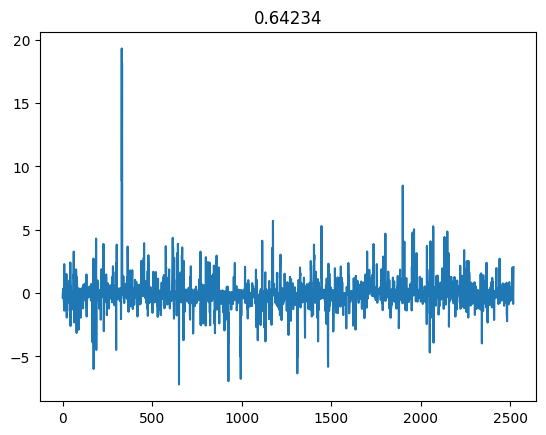

(840, 3)

In [148]:
diff = np.array(outs).reshape(-1)-np.array(outs_exact).reshape(-1)

plt.plot(diff)
plt.title(f"{np.mean(np.abs(np.array(outs).reshape(-1)-np.array(outs_exact).reshape(-1))):.5f}")
plt.show()
np.array(outs).shape

In [149]:
with torch.no_grad():
    out_list = []
    label_list = []
    n_samples = 0
    n_diff = 0
    meh = []
    for dat, labs in loader_test:
        if len(dat.shape)>3:
            dat = dat.reshape(batch_size_tst, input_size, time_series)
        if len(labs.shape)>2:
            labs = labs.reshape(batch_size_tst, time_series)
        
        if network=="FNN":
            labs = labs.reshape(batch_size_tst, -1).to(device)
            sample = dat.reshape(batch_size_tst, -1).to(device)
        elif network=="CNN":
            labs = labs.to(device)
            sample = dat.to(device)

        label_list += labs.tolist()

        outputs = model(sample) # trained model
        out_list += outputs.tolist()
        n_diff += torch.mean(torch.abs(outputs-labs))
        meh += (outputs-labs).tolist()
        n_samples += 1

    acc = n_diff/n_samples

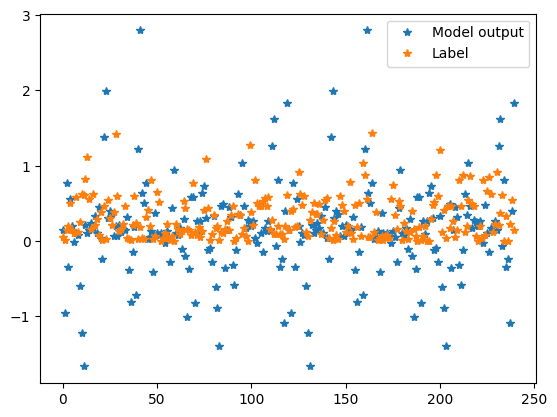

In [150]:
out_list = np.array(out_list).reshape(-1)
label_test = np.array(label_test).reshape(-1)

plt.plot(out_list, "*", label="Model output")
plt.plot(label_test[:len(out_list)], "*", label="Label")
plt.legend()
plt.show()

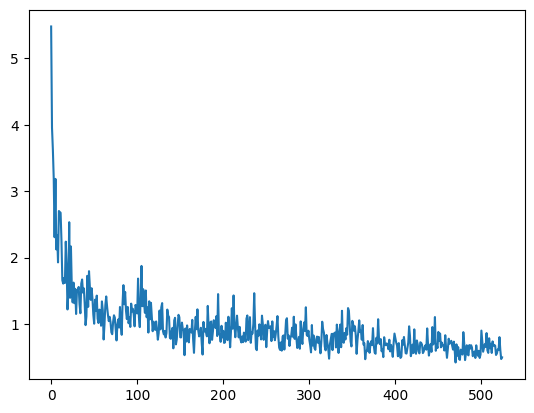

In [151]:
loss_train = np.array(loss_train)

plt.plot(loss_train)